In [14]:
!pip install bs4
!pip install pysolar

  Using cached bs4-0.0.1.tar.gz (1.1 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1272 sha256=e45e74f5a929caac60b8c48493fb8f1efef4f2223ecfe1007969a7829efca72a
  Stored in directory: c:\users\dlhogan\appdata\local\pip\cache\wheels\73\2b\cb\099980278a0c9a3e57ff1a89875ec07bfa0b6fcbebb9a8cad3
Successfully built bs4
  Using cached pysolar-0.10-py3-none-any.whl (47 kB)


In [3]:
import os
import requests
import re

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import bs4
import pysolar
import datetime as dt

In [4]:
data_path = os.path.join(os.getcwd(), 'data\\raw\\gml_noaa')
url = 'https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/'

In [5]:
data_path

'c:\\Users\\dlhogan\\OneDrive - UW\\Documents\\GitHub\\sublimation_of_snow\\data\\raw\\gml_noaa'

In [69]:
def download_files(url, save_path):
    os.chdir(save_path)
    r = requests.get(url)
    data = bs4.BeautifulSoup(r.text, "html.parser")
    for l in data.find_all('a', href=re.compile("\.dat$")):
        filename = l.get('href')
        outpath = os.path.join(save_path, filename)
        
        if not os.path.exists(outpath):
            print(f'Fetching {filename}...')
            url = 'https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/' + filename
            myfile = requests.get(url)
            open(filename, 'wb').write(myfile.content)

In [159]:
def met_data_formatting(fn):
    # read in data
    ckp_df = pd.read_table(fn, skiprows=2, header=None, delim_whitespace=True, parse_dates={'DateTime':[0,2,3,4,5]}, infer_datetime_format=True)
    # Convert DateTime column to datetime
    ckp_df['DateTime'] = pd.to_datetime(ckp_df['DateTime'], format='%Y %m %d %H %M')
    # Add column numbers
    col_num = [1,2,3,4,5,6,7,8,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51]
    col_num = [num - 1 for num in col_num]
    col_names = ["yyyy","jday","month","day","hour","min","dt","SZA","dw_solar","uw_solar","Direct horizontal","Diffuse",
                "dw_ir","DwCaseTemp","DwDomeTemp","uw_ir","UwCaseTemp","UwDomeTemp","UVB","PAR","NetSolar","NetIR",
                "TotalNet","AirTemp","RH","WindSpd","WindDir","Baro","SPN1_total_Avg","SPN1_diffuse_Avg"]
    ckp_df = ckp_df.rename(columns = dict(zip(col_num, col_names))) 
    # Create QC column names
    qc_col_numbers = ckp_df.columns[4::2]
    new_qc_names = [col_name +'_qc' for col_name in a.columns[3::2]]
    ckp_df = ckp_df.rename(columns = dict(zip(qc_col_numbers,new_qc_names))) 
    return ckp_df


In [7]:
filenames = [os.path.join(data_path,fn) for fn in os.listdir(data_path)]

In [237]:
int(os.path.split(filenames[0])[1].replace('ckp21','').rstrip('.dat'))

288

In [1]:
import xarray

In [160]:
ckp = pd.DataFrame()
for file in filenames[80:103]:
    if os.path.exists(file):
        ckp = pd.concat([ckp,met_data_formatting(file)])
ckp.head()

,DateTime,jday,dt,SZA,dw_solar_qc,9,uw_solar_qc,11,Direct horizontal_qc,13,...,WindSpd_qc,43,WindDir_qc,45,Baro_qc,47,SPN1_total_Avg_qc,49,SPN1_diffuse_Avg_qc,51
0,2022-01-03 00:00:00,3,0.000,91.18,3.0,0,2.6,0,3.0,0,...,0.7,0,297.9,0,724.8,0,0.5,0,0.0,0
1,2022-01-03 00:01:00,3,0.017,91.35,2.6,0,2.4,0,2.6,0,...,0.6,0,303.3,0,724.8,0,0.6,0,0.0,0
2,2022-01-03 00:02:00,3,0.033,91.52,2.3,0,2.1,0,2.3,0,...,0.5,0,304.8,0,724.8,0,0.4,0,0.0,0
3,2022-01-03 00:03:00,3,0.050,91.69,1.9,0,1.8,0,1.9,0,...,0.7,0,308.6,0,724.8,0,0.5,0,0.0,0
4,2022-01-03 00:04:00,3,0.067,91.86,1.6,0,1.6,0,1.6,0,...,1.3,0,305.3,0,724.8,0,0.9,0,0.0,0


In [144]:

# group by average minute data
a = ckp.groupby([ckp['DateTime'].dt.date, ckp['DateTime'].dt.hour,ckp['DateTime'].dt.minute]).mean()
a.index = a.index.map(lambda idx: f'{idx[0]} {idx[1]} {idx[2]}')
a.index = pd.to_datetime(a.index, format='%Y-%m-%d %H %M', utc=True).tz_convert("US/Mountain")

<AxesSubplot:>

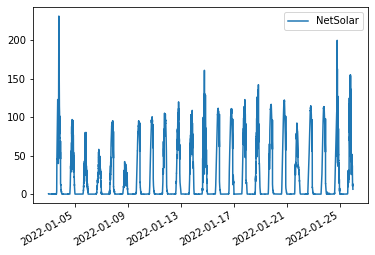

In [112]:
a[a['NetSolar'] >=0].plot(y='NetSolar')

In [140]:
# potential solar radiation at Kettle Ponds
lat = 38.941667
lon = -106.973056
timezone = dt.timezone(dt.timedelta(hours=-7))
start = dt.datetime(2022, 1, 5, tzinfo=timezone)

# Calculate radiation every hour for 90 days
nhr = 24*20
dates, altitudes_deg, radiations = pd.Series(index=range(nhr), dtype='object'), pd.Series(index=range(nhr), dtype='float64'), pd.Series(index=range(nhr),dtype='float64')
for i,ihr in enumerate(range(nhr)):
    date = start + dt.timedelta(hours=ihr)
    altitude = pysolar.solar.get_altitude(lat,lon,date)
    if altitude <= 0:
        radiation = 0.
    else:
        radiation = pysolar.radiation.get_radiation_direct(date,altitude)
    dates[i]=date
    altitudes_deg[i]=altitude
    radiations[i]=radiation

In [38]:
mask = a != -9999
a = a[mask]

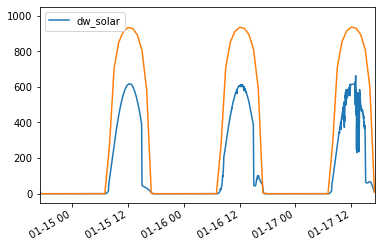

In [143]:
fig,ax = plt.subplots()
a[a['dw_solar'] >=0].plot(y='dw_solar',ax=ax)
ax.plot(dates,radiations)
ax.set_xlim(dt.datetime(2022,1,15,0,0), dt.datetime(2022,1,18,0,0));

In [22]:
# !pip install windrose
import windrose

In [72]:
wind_df = a[['WindSpd','WindDir']]

Text(0.5, 1.0, 'Windrose Jan 2022')

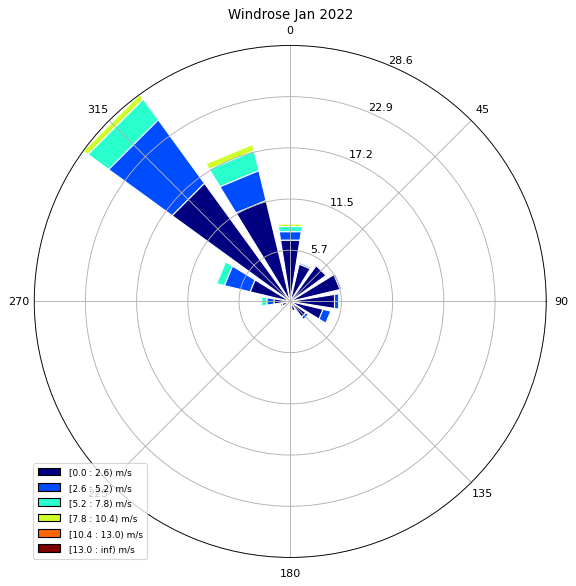

In [75]:
ax = windrose.WindroseAxes.from_ax();
ax.bar(wind_df['WindDir'], wind_df['WindSpd'], normed=True, opening=0.8, edgecolor='white');
ax.set_xticklabels((90, 45, 0, 315, 270, 225, 180, 135))
ax.set_legend(units='m/s');
ax.set_title('Windrose Jan 2022');

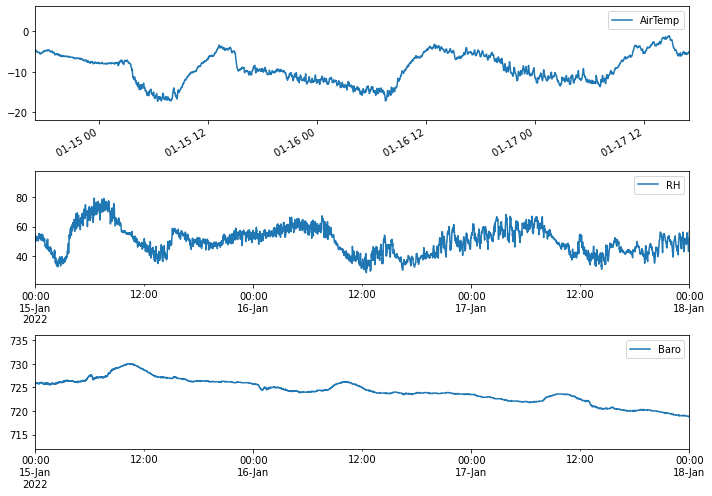

In [145]:
fig,axs = plt.subplots(nrows=3, figsize=(10,7), tight_layout=True)
a[a['AirTemp'] > -100].plot(y='AirTemp', use_index=True, ax=axs[0])
a.plot(y='RH',use_index=True, ax=axs[1])
a.plot(y='Baro',use_index=True, ax=axs[2])
for ax in axs:
    ax.set_xlim(dt.datetime(2022,1,15,0,0), dt.datetime(2022,1,18,0,0));

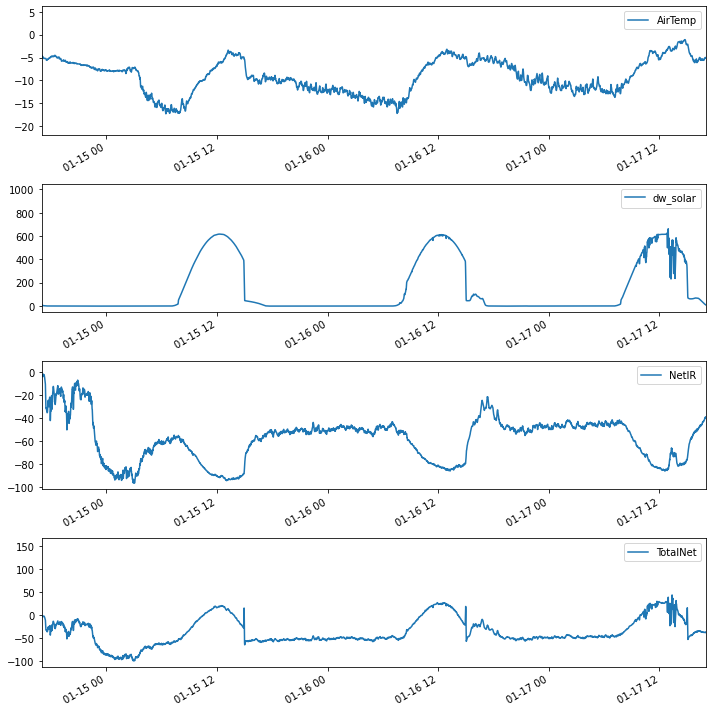

In [146]:
fig,axs = plt.subplots(nrows=4, figsize=(10,10), tight_layout=True)
a[a['AirTemp'] > -100].plot(y='AirTemp',ax=axs[0])
a[a['NetSolar'] > -100].plot(y='dw_solar',ax=axs[1])
a[a['NetIR'] > -100].plot(y='NetIR',ax=axs[2])
a[a['TotalNet'] > -100].plot(y='TotalNet',ax=axs[3])
for ax in axs:
    ax.set_xlim(dt.datetime(2022,1,15,0,0), dt.datetime(2022,1,18,0,0));

